# Visualisation des anomalies

In [194]:
import pandas as pd
import numpy as np
import scipy.stats as sps

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Scikit learn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier 

#Lecture des données 
import pickle

In [2]:
#path_test = "../../4A/Projet/Ensemble de test/"
path_test = "../Donnees_projet/Ensemble_de_test/"

In [3]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_propre, ind_recupere = mon_depickler.load()

In [4]:
def enlever_pic(serie, seuil=10, pts_moy=2, plot=False) :
    """Retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. Les accroissements sont moyennés sur plusieurs points pour ne pas être sensibles 
    aux possibles irrégularités dans le pic.
    L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne la liste tronquée"""
    serie = np.array(serie)
    if plot :
        plt.plot(serie)
        
    accr = abs(serie[1:] - serie[:-1])
    moy_accr = [np.mean(accr[i : i + pts_moy]) for i in range(len(accr) - pts_moy)]

    for ind, val in enumerate(moy_accr[::-1]) :
        if val < seuil and ind >= 1 :
            if plot :
                plt.plot(serie[:-ind], color="red")
                plt.show()
                
            return list(serie[:-ind])
            break
    else : 
        return serie

In [5]:
n = len(liste_propre)
liste_appr = list(np.asarray(liste_propre)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(liste_propre)[np.asarray(ind_recupere) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

In [6]:
anom = [False] * n_test
type_anom = [-1] * n_test
loc = [-1] * n_test

anom[73] = True
type_anom[73] = 1
loc[73] = 200

anom[96] = True
type_anom[96] = 1
loc[96] = 300

anom[36] = True
type_anom[36] = 1
loc[36] = 400

anom[32] = True
type_anom[32] = 1
loc[32] = 300

anom[33] = True
type_anom[33] = 1
loc[33] = 200

anom[107] = True
type_anom[107] = 2
loc[107] = 600

anom[60] = True
type_anom[60] = 2
loc[60] = 400

anom[113] = True
type_anom[113] = 2
loc[113] = 400

anom[9] = True
type_anom[9] = 2
loc[9] = 200

anom[11] = True
type_anom[11] = 2
loc[11] = 300

anom[53] = True
type_anom[53] = 3
loc[53] = 400

anom[114] = True
type_anom[114] = 3
loc[114] = 400

anom[14] = True
type_anom[14] = 3
loc[14] = 500

anom[79] = True
type_anom[79] = 3
loc[79] = 400

anom[29] = True
type_anom[29] = 3
loc[29] = 300

anom[27] = True
type_anom[27] = 4
loc[27] = 300

anom[121] = True
type_anom[121] = 4
loc[121] = 300

anom[5] = True
type_anom[5] = 4
loc[5] = 400

anom[89] = True
type_anom[89] = 4
loc[89] = 200

anom[99] = True
type_anom[99] = 4
loc[99] = 100  

anom = [False] * n_appr + anom
type_anom = [-1] * n_appr + type_anom
loc = [-1] * n_appr + loc

In [18]:
ind_anom = list(np.where(np.asarray(anom))[0]) # Indices des anomalies

In [9]:
def df_fenetres(liste_comp, N, anom, loc):
    serie = []
    #origine = []
    ind_debut = []
    valeurs = []
    anom_fen = []
    for i, val, loc_i in zip(ind_recupere, liste_comp, loc):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        anom_fen_i = [False] * nb_fen
        pos_anom_deb_fen = loc_i // N
        pos_anom_fin_fen = (loc_i + 55) // N
        if loc_i > -1:
            try:
                for pos in range(pos_anom_deb_fen, pos_anom_fin_fen + 1):
                    anom_fen_i[pos] = True

            except IndexError:
                pass
                """Cette erreur est levée lorsque l'anomalie se trouve en fin de série, dans une plage qui n'a pas été capturée 
                par une des fenêtres. On peut donc l'ignorer et continuer le traitement. Ce cas est de toute façon très rare
                dans nos données."""
        anom_fen += anom_fen_i
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
        """if i < 300:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen"""
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "ind_debut" : ind_debut, "valeurs" : valeurs, "anom" : anom_fen})
        
    return df.set_index(["id"])

In [69]:
N = 100
data_fenetres = df_fenetres(liste_propre, N, anom, loc)

In [70]:
ind_anom = list(data_fenetres[data_fenetres["anom"]]["serie"].values)

In [73]:
data_ajout_anom = data_fenetres.loc[data_fenetres["serie"].isin(ind_anom)]
offset = 10 ** (int(np.log10(data_fenetres.index.values[-1])) + 1)

# il faut recopier toutes les séries dans lesquelles il y a une anomalie et pas juste les fenetres
df_supervise = data_fenetres
for i in range(1,5):
    data_ajout_anom.index += offset
    df_supervise = pd.concat([df_supervise, data_ajout_anom])
    
#df supervise contient les données d'apprentissage + les données de tests + les séries anormales recopiées 4 fois
# les séries recopiées ont pour indice leur indice de départ + k*offset pour k=1,..,4
df_supervise.tail(50)

,serie,ind_debut,valeurs,anom
id,,,,
42402,373,0,"[1432.0, 1432.0, 1432.0, 1440.0, 1448.0, 1448....",False
42403,373,100,"[1664.0, 1680.0, 1680.0, 1680.0, 1680.0, 1680....",False
42404,373,200,"[1678.0, 1686.0, 1678.0, 1678.0, 1662.0, 1678....",True
42405,373,300,"[1728.0, 1736.0, 1744.0, 1744.0, 1744.0, 1736....",False
42406,373,400,"[1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 1408....",False
42452,379,0,"[1408.0, 1408.0, 1408.0, 1416.0, 1408.0, 1400....",False
42453,379,100,"[1696.0, 1696.0, 1704.0, 1704.0, 1704.0, 1696....",False
42454,379,200,"[1744.0, 1744.0, 1736.0, 1736.0, 1736.0, 1744....",False
42455,379,300,"[1736.0, 1736.0, 1736.0, 1736.0, 1736.0, 1744....",False


In [88]:
def plot_anom_type(Type):
    for num in df_supervise.index.values:
        TS = df_supervise.loc[num]
        loc = TS["loc"]
        serie = TS["valeurs"]

        if TS["type"] == Type: 
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.title("Série numéro " + str(num) + ", type " + str(Type), size=20, color='r', fontweight='bold')

            ax.plot(range(loc), serie[: loc], 'b')
            ax.plot(range(loc - 1, loc + 56), serie[loc - 1 : loc + 56], 'r')
            ax.plot(range(loc + 55, len(serie)), serie[loc + 55 :], 'b')

        plt.show()

In [94]:
try:
    for T in range(1, 5):
        plot_anom_type(T)
except KeyError:
    print("Marche plus avec le nouveau DataFrame, à adapter si besoin.")

Marche plus avec le nouveau DataFrame, à adapter si besoin.


## 3 - Méthodes de Classification

## Random Forest

### Calcul des features

In [220]:
df_supervise["min"] = list(map(min, df_supervise.valeurs))
df_supervise["max"] = list(map(max, df_supervise.valeurs))
df_supervise["mean"] = list(map(np.mean, df_supervise.valeurs))
df_supervise["std"] = list(map(np.std, df_supervise.valeurs))
df_supervise["skew"] = list(map(sps.skew, df_supervise.valeurs))
df_supervise["kurt"] = list(map(sps.kurtosis, df_supervise.valeurs))
df_supervise["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), df_supervise.valeurs))
df_supervise["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), df_supervise.valeurs))

In [245]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    df_supervise[col] = scaler.fit_transform(df_supervise[col].values.reshape(-1, 1))

In [246]:
df_supervise.shape

(3254, 12)

In [247]:
X_train, X_test, Y_train, Y_test = train_test_split(df_supervise[names_features], df_supervise["anom"], test_size=2500)

In [248]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)


0.0053050397877983935


In [249]:
# erreur de prévision sur le test
1-rfFit.score(X_test,Y_test)

0.011199999999999988

In [250]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.007958, Meilleur paramètre = {'max_features': 4}


In [251]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test,Y_test)

0.012800000000000034

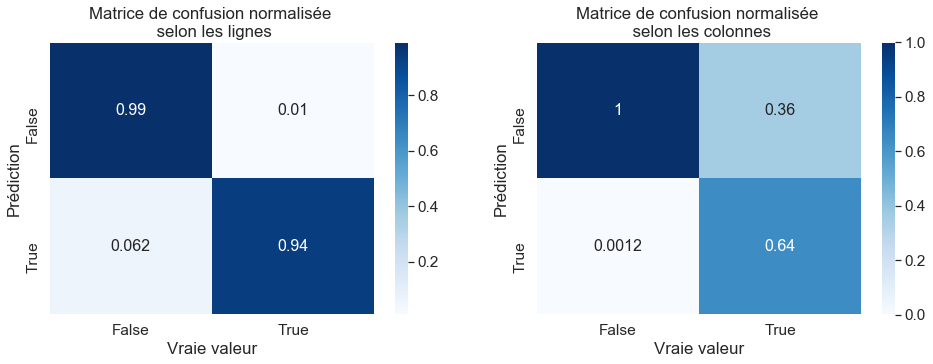

In [252]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : 1,2% d'erreurs, c'est très faible mais si on regarde la matrice de confusion on voit que la prévision n'est en fait pas si efficace. En effet on observe beaucoup de faux négatifs, envion un tiers. On a pas contre quasi aucun faux positif.

On teste la même chose mais sans dupliquer les anomalies.

In [159]:
data_fenetres["min"] = list(map(min, data_fenetres.valeurs))
data_fenetres["max"] = list(map(max, data_fenetres.valeurs))
data_fenetres["mean"] = list(map(np.mean, data_fenetres.valeurs))
data_fenetres["std"] = list(map(np.std, data_fenetres.valeurs))
data_fenetres["skew"] = list(map(sps.skew, data_fenetres.valeurs))
data_fenetres["kurt"] = list(map(sps.kurtosis, data_fenetres.valeurs))
data_fenetres["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), data_fenetres.valeurs))
data_fenetres["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), data_fenetres.valeurs))

In [160]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

In [161]:
data_fenetres.shape

(2778, 12)

In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(data_fenetres[names_features], data_fenetres["anom"], test_size=500)

In [175]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

0.0065847234416154254


In [176]:
# erreur de prévision sur le test
1-rfFit.score(X_test,Y_test)

0.006000000000000005

In [177]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.006146, Meilleur paramètre = {'max_features': 5}


In [178]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test,Y_test)

0.006000000000000005

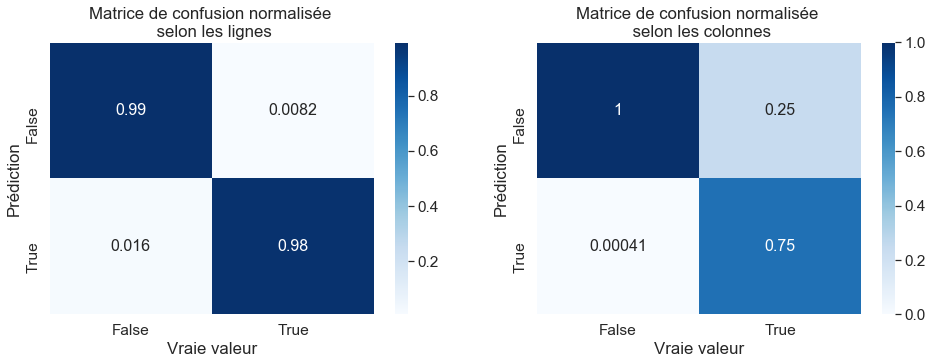

In [243]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : Le modèle répond quasi systématiquement Non, et donc se trompe très peu. C'est parfaitement inexploitable, il faut garder la version en dupliquant les anomalies ou trouver une autre idée.

(Et oui, il est tard mais j'ai pas pu m'empêcher de faire un joli plot qui sert pas à grand-chose)